# **Dataiku Data Scientist Technical Assessment**
### Author : Jules Boistard
### Submission date : January 18th, 2022
___

#### **#1 : Exploratory data analysis**

##### **1.1 : Importing the dataset**

In [1]:
# Read the train and test files
import pandas as pd
import re

metadata = open("data/census_income_metadata.txt")
col_names = [re.findall("\(([^\)]+)\)", line)[0] for line in metadata.readlines()[81:121]]
col_names.append("total person income")

train = pd.read_csv("data/census_income_learn.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)
test = pd.read_csv("data/census_income_test.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)

'''
Note : column #24 in the csv corresponds to the instance weight.
While it will be kept for exploratory data analysis, we will later on remove it to train the classifiers.
It is therefore treated separately in this section and added as last column.
'''
train["instance weight"] = pd.read_csv("data/census_income_learn.csv", header=None, sep=", ", na_values="?", usecols=[24])
test["instance weight"] = pd.read_csv("data/census_income_test.csv", header=None, sep=", ", na_values="?", usecols=[24])

e:\dataiku_assessment\venv\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


##### **1.2 : Identify duplicates and conflicts in data**

As stated in the metadata file, the train and test sets respectively contains a fairly large number of duplicates or conflictided instances, precisely :
- 46716 obervations for the train set
- 20936 observations for the test set

This can be easily verified, as shown below, counting duplicates while excluding instance weight and target variable

In [2]:
nb_dc_train = train.drop(["instance weight", "total person income"], axis=1).duplicated().sum()
nb_dc_test  = test.drop(["instance weight", "total person income"], axis=1).duplicated().sum()
print("Number of duplicates/conflicts in train set : ", nb_dc_train)
print("Number of duplicates/conflicts in test set : ", nb_dc_test)
print ("Total number of duplicates : ", nb_dc_train + nb_dc_test)

Number of duplicates/conflicts in train set :  46716
Number of duplicates/conflicts in test set :  20936
Total number of duplicates :  67652


We need to adress this issue right away, as it could potentially hurt our analysis and machine learning model a lot later on. We can go a little bit further by dissociating duplicates (identical observations with same target) from conflicts (identical observations with different targets)

In [3]:
dc_train = train.drop(["instance weight", "total person income"], axis=1).duplicated()
duplicates_train = train.drop(["instance weight"], axis=1).duplicated()
conflicts_train = (dc_train & ~duplicates_train)

dc_test= test.drop(["instance weight", "total person income"], axis=1).duplicated()
duplicates_test = test.drop(["instance weight"], axis=1).duplicated()
conflicts_test = (dc_test & ~duplicates_test)

print("Number of duplicate/conflicts over whole dataset : ", dc_train.sum() + dc_test.sum())
print("- Including ", duplicates_train.sum(), " duplicates in train set")
print("- Including ", conflicts_train.sum(), " conflicts in train set")
print("- Including ", duplicates_test.sum(), " duplicates in train set")
print("- Including ", conflicts_test.sum(), " conflicts in train set")


Number of duplicate/conflicts over whole dataset :  67652
- Including  46627  duplicates in train set
- Including  89  conflicts in train set
- Including  20898  duplicates in train set
- Including  38  conflicts in train set


Let us look at an example of a duplicate entry (in the train set)

In [31]:
pd.set_option('display.max_columns', 50)

random_duplicate_idx = duplicates_train[duplicates_train].sample(random_state=5).index
ref_entry = train.iloc[random_duplicate_idx]
df_sample = train.copy()
for col in train.drop(["instance weight"], axis=1).columns:
    ref_value = ref_entry[col].iloc[0]
    if not pd.isnull(ref_value):
        df_sample = df_sample[df_sample[col] == ref_value]
df_sample

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,total person income,instance weight
137373,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,South,Utah,Child <18 never marr not in subfamily,Child under 18 never married,MSA to MSA,Same county,Same county,No,Yes,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,2738.79
197426,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,South,Utah,Child <18 never marr not in subfamily,Child under 18 never married,MSA to MSA,Same county,Same county,No,Yes,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,3040.58


We can see from the above example that there are 2 identical entries, **target variable included** (it could be a lot more than 2).

To delete duplicates, we can merge these lines and add up the instance weights, in the training set and test set separately

In [44]:
train_without_duplicates = train.groupby([col for col in train.drop(["instance weight"], axis=1).columns],dropna=False)["instance weight"].sum().reset_index()
test_without_duplicates = test.groupby([col for col in test.drop(["instance weight"], axis=1).columns],dropna=False)["instance weight"].sum().reset_index()

# Quick verification that we have exactly the initial number of entries minus the previously identified number of duplicates in each set
print("Dropped entries for train set : ", len(train) - len(train_without_duplicates))
print("Dropped entries for test set : ", len(test) - len(test_without_duplicates))

Dropped entries for train set :  46627
Dropped entries for test set :  20898


Let us now look at an example of conflicting instances in data (in the train set still)

In [50]:
# Since indexes have been reset in the previous operation, we need to re-compute the indexes of conflicting instances
conflicts_train = train_without_duplicates.drop(["instance weight", "total person income"], axis=1).duplicated()
conflicts_test = test_without_duplicates.drop(["instance weight", "total person income"], axis=1).duplicated()

print(conflicts_train.sum())
print(conflicts_test.sum())

89
38


In [51]:
random_conflict_idx = conflicts_train[conflicts_train].sample(random_state=5).index
ref_entry = train_without_duplicates.iloc[random_conflict_idx]
df_sample = train_without_duplicates.copy()
for col in train_without_duplicates.drop(["instance weight", "total person income"], axis=1).columns:
    ref_value = ref_entry[col].iloc[0]
    if not pd.isnull(ref_value):
        df_sample = df_sample[df_sample[col] == ref_value]
df_sample

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,total person income,instance weight
123946,58,Private,32,18,Some college but no degree,0,Not in universe,Married-civilian spouse present,Wholesale trade,Sales,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,3349.55
123947,58,Private,32,18,Some college but no degree,0,Not in universe,Married-civilian spouse present,Wholesale trade,Sales,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,50000+.,2285.73


This time, every thing is identical except for the target value (total person income). Since we want to avoid conflicting instances, we can keep the one with the highest instance weight for each group of n conflicting observations (this would be the first row in the above example)

In [77]:
train_without_dc = train_without_duplicates.groupby([col for col in train.drop(["instance weight"], axis=1).columns], dropna=False, group_keys=False).apply(lambda x: x.loc[x["instance weight"].idxmax()]).reset_index()
test_wuthout_dc = test_without_duplicates.groupby([col for col in test.drop(["instance weight"], axis=1).columns], dropna=False, group_keys=False).apply(lambda x: x.loc[x["instance weight"].idxmax()]).reset_index()


age  \
age class of worker                detailed industry recode detailed occupation recode education                              wage per hour enroll in edu inst last wk marital stat                    major industry code         major occupation code           race                        hispanic origin sex    member of a labor union reason for unemployment full or part time employment stat capital gains capital losses dividends from stocks tax filer stat               region of previous residence state of previous residence detailed household and family stat      detailed household summary in household migration code-change in msa migration code-change in reg  migration code-move within reg live in this house 1 year ago    migration prev res in sunbelt num persons worked for employer family members under 18 country of birth father country of birth mother country of birth self citizenship                       own business or self employed fill inc questionnaire for veteran's admin veterans benefits weeks worked in year year total person income        
0   Not in universe                0                        0                          Children                               0             Not in universe            Married-civilian spouse present Not in universe or children Not in universe                 White                       All other       Female Not in universe         Not in universe         Children or Armed Forces          0             0              0                     Joint one under 65 & one 65+ Not in universe              Not in universe             Spouse of householder                   Spouse of householder                   Not in universe              Not in universe               Not in universe                Not in universe under 1 year old Not in universe               0                               Not in universe         United-States           United-States           United-States         Native- Born in the United States 0                             Not in universe                            2                 0                    94   - 50000.               0   
                                                                                                                                                                       Never married                   Not in universe or children Not in universe                 Amer Indian Aleut or Eskimo All other       Female Not in universe         Not in universe         Children or Armed Forces          0             0              0                     Nonfiler                     Not in universe              Not in universe             Child <18 never marr not in subfamily   Child under 18 never married            Not in universe              Not in universe               Not in universe                Not in universe under 1 year old Not in universe               0                               Both parents present    United-States           United-States           United-States         Native- Born in the United States 0                             Not in universe                            0                 0                    94   - 50000.               0   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [68]:
def remove_conflicts(data, conflicts):
    df = data.copy()
    idxs_to_drop = []
    for conflict_idx in conflicts[conflicts].index:
        for col in data.drop(["instance weight", "total person income"], axis=1).columns:
            ref_value = data.iloc[conflict_idx][col]
            if not pd.isnull(ref_value):
                df_conflicts = data[data[col] == ref_value]
                idx_to_keep = df_conflicts["instance weight"].argmax()
                idxs_to_drop.extend([idx for idx in df_conflicts.index if idx != idx_to_keep])
    df = df[~df.index.isin(idxs_to_drop)]
    return df

train_without_dc = remove_conflicts(train_without_duplicates, conflicts_train)
test_without_dc = remove_conflicts(test_without_duplicates, conflicts_train)

KeyboardInterrupt: 

##### **1.3 : Looking into missing values**

In [25]:
# Identify categorical columns in the dataset (pre-identified in metadata file)
num_cols = ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "num persons worked for employer", "weeks worked in year", "instance weight"]
cat_cols = [col for col in train.columns if col not in num_cols and col != "total person income"]

train["set"] = "train"
test["set"] = "test"

data = pd.concat([train, test], ignore_index=True)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

<AxesSubplot:>

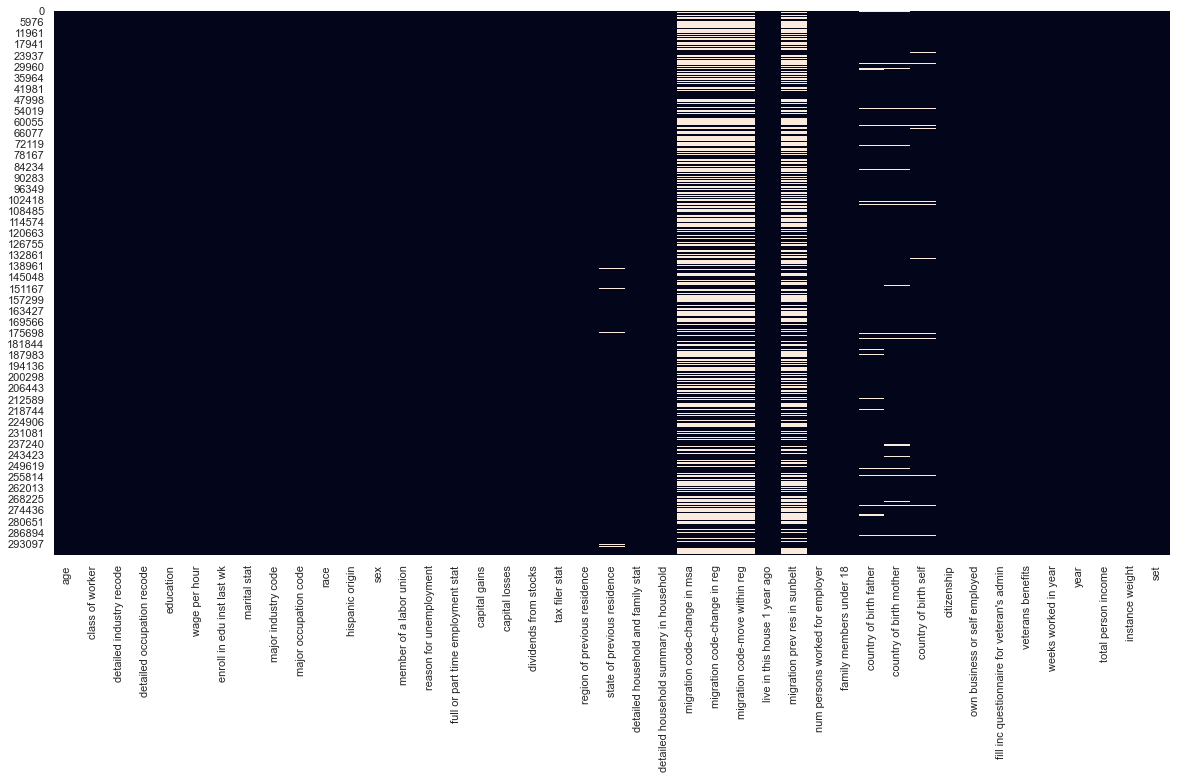

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(data.isna(), cbar=False)

In [7]:
nan_rate = data.isna().sum() / len(data)
nan_rate.sort_values(ascending=False).head(10)

migration code-change in msa      0.499542
migration code-change in reg      0.499542
migration code-move within reg    0.499542
migration prev res in sunbelt     0.499542
country of birth father           0.034592
country of birth mother           0.031342
country of birth self             0.017604
hispanic origin                   0.004338
state of previous residence       0.003534
citizenship                       0.000000
dtype: float64

From the above, we can separate the 9 variables with missing values into 2 groups :
- Top 4 : they have near 50% of missing values, so we will probably drop them altogether in preprocessing later on
- Bottom 5 : they have a rather low rate of missing values, therefore imputation could be a viable option

##### 1.3 : Analyzing continuous variables distribution

In [8]:
# Look at descriptive stats for numerical features
data.describe()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,instance weight
count,292550.000000,292550.000000,292550.000000,292550.000000,292550.000000,292550.000000,292550.000000,292550.000000
mean,35.148737,56.369147,441.681617,37.697337,200.322198,2.000848,23.708146,1743.826881
std,22.174974,276.334763,4723.762662,272.819017,1959.711763,2.372970,24.425794,998.184553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.870000
25%,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1060.440000
50%,34.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000,1620.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,4.000000,52.000000,2195.950000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,52.000000,18656.300000


We can detect a couple of things from the above statistics :
- Wage, capital gains (and losses ?) and dividends seem to have been capped @ 9999 and 99999
- The nb of persons working for employer seem strangely low, which seems to indicate that the data have been mapped
- The average worked weeks seem very low, probably accounting for children and retired people in the sample

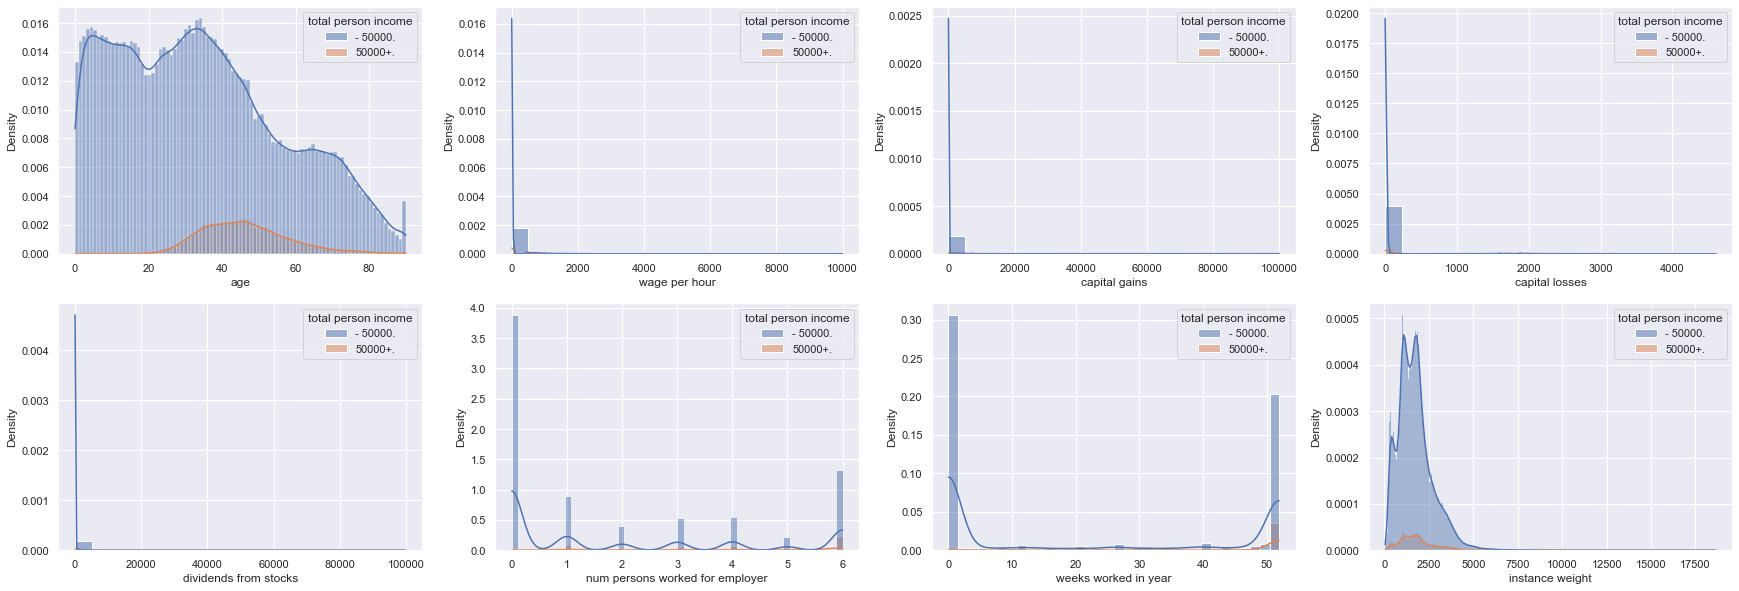

In [9]:
# Show density plot for all the continuous variables
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))
for i, col in enumerate(num_cols):
    sns.histplot(data, x=col, hue="total person income", stat="density", kde=True, ax=axs.flatten()[i])

As a side note, we can clearly spot the heavy unbalance between our two target classes, which will we discuss later on

**Age**
- Nothing seems abnormal, most represented individuals are kids around 10 and adults in their late 30s
- Proportionnaly, we can see that the 50k+ income class seems to include generally older individuals
- Nonetheless, classes largely overlap

**Wage per hour, capital gain, capital losses, dividends from stocks**
- Heavily skewed distributions : very few individuals show non-zero values for these variables (as shown below)
- We might consider dropping these features later on

In [10]:
print("Rate of non-zero values for : ")
for col in ["wage per hour", "capital gains", "capital losses", "dividends from stocks"]:
    print(col + " : " + str(len(data[data[col] > 0])/len(data)))

Rate of non-zero values for : 
wage per hour : 0.057720047855067506
capital gains : 0.03794565031618527
capital losses : 0.019873525893009742
dividends from stocks : 0.10824132626901384


**Num persons worked for employer**
- WARNING --> The plot actually allows us to identify that this continuous variable **has been mapped to a discrete one**
- We could therefore consider treating it as a categorical variable
- Since the number still reflects the magnitude, we can keep it as it is. Alternatively, we could use ordinal encoding to preserve relationship between values

**Weeks worked in year**
- It seems there is a unusually high number of people that have worked 0 weeks during the year.
- In reality, those can either correspond to children under 15, retired adults, or actually unemployed adults
- The additional plot below confirms that the 'reason for unemployment' variable enables us to distinguish the first 2 from the latter

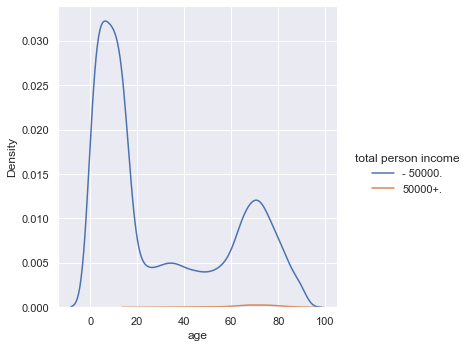

In [11]:
# This plot shows the age distribution for people who did not work during the year but are not identified as 'unemployed' either
sns.displot(data[(data["weeks worked in year"] == 0) & (data["reason for unemployment"] == "Not in universe")], x="age", kind="kde", hue="total person income")

##### 1.4 : Looking into categorical features

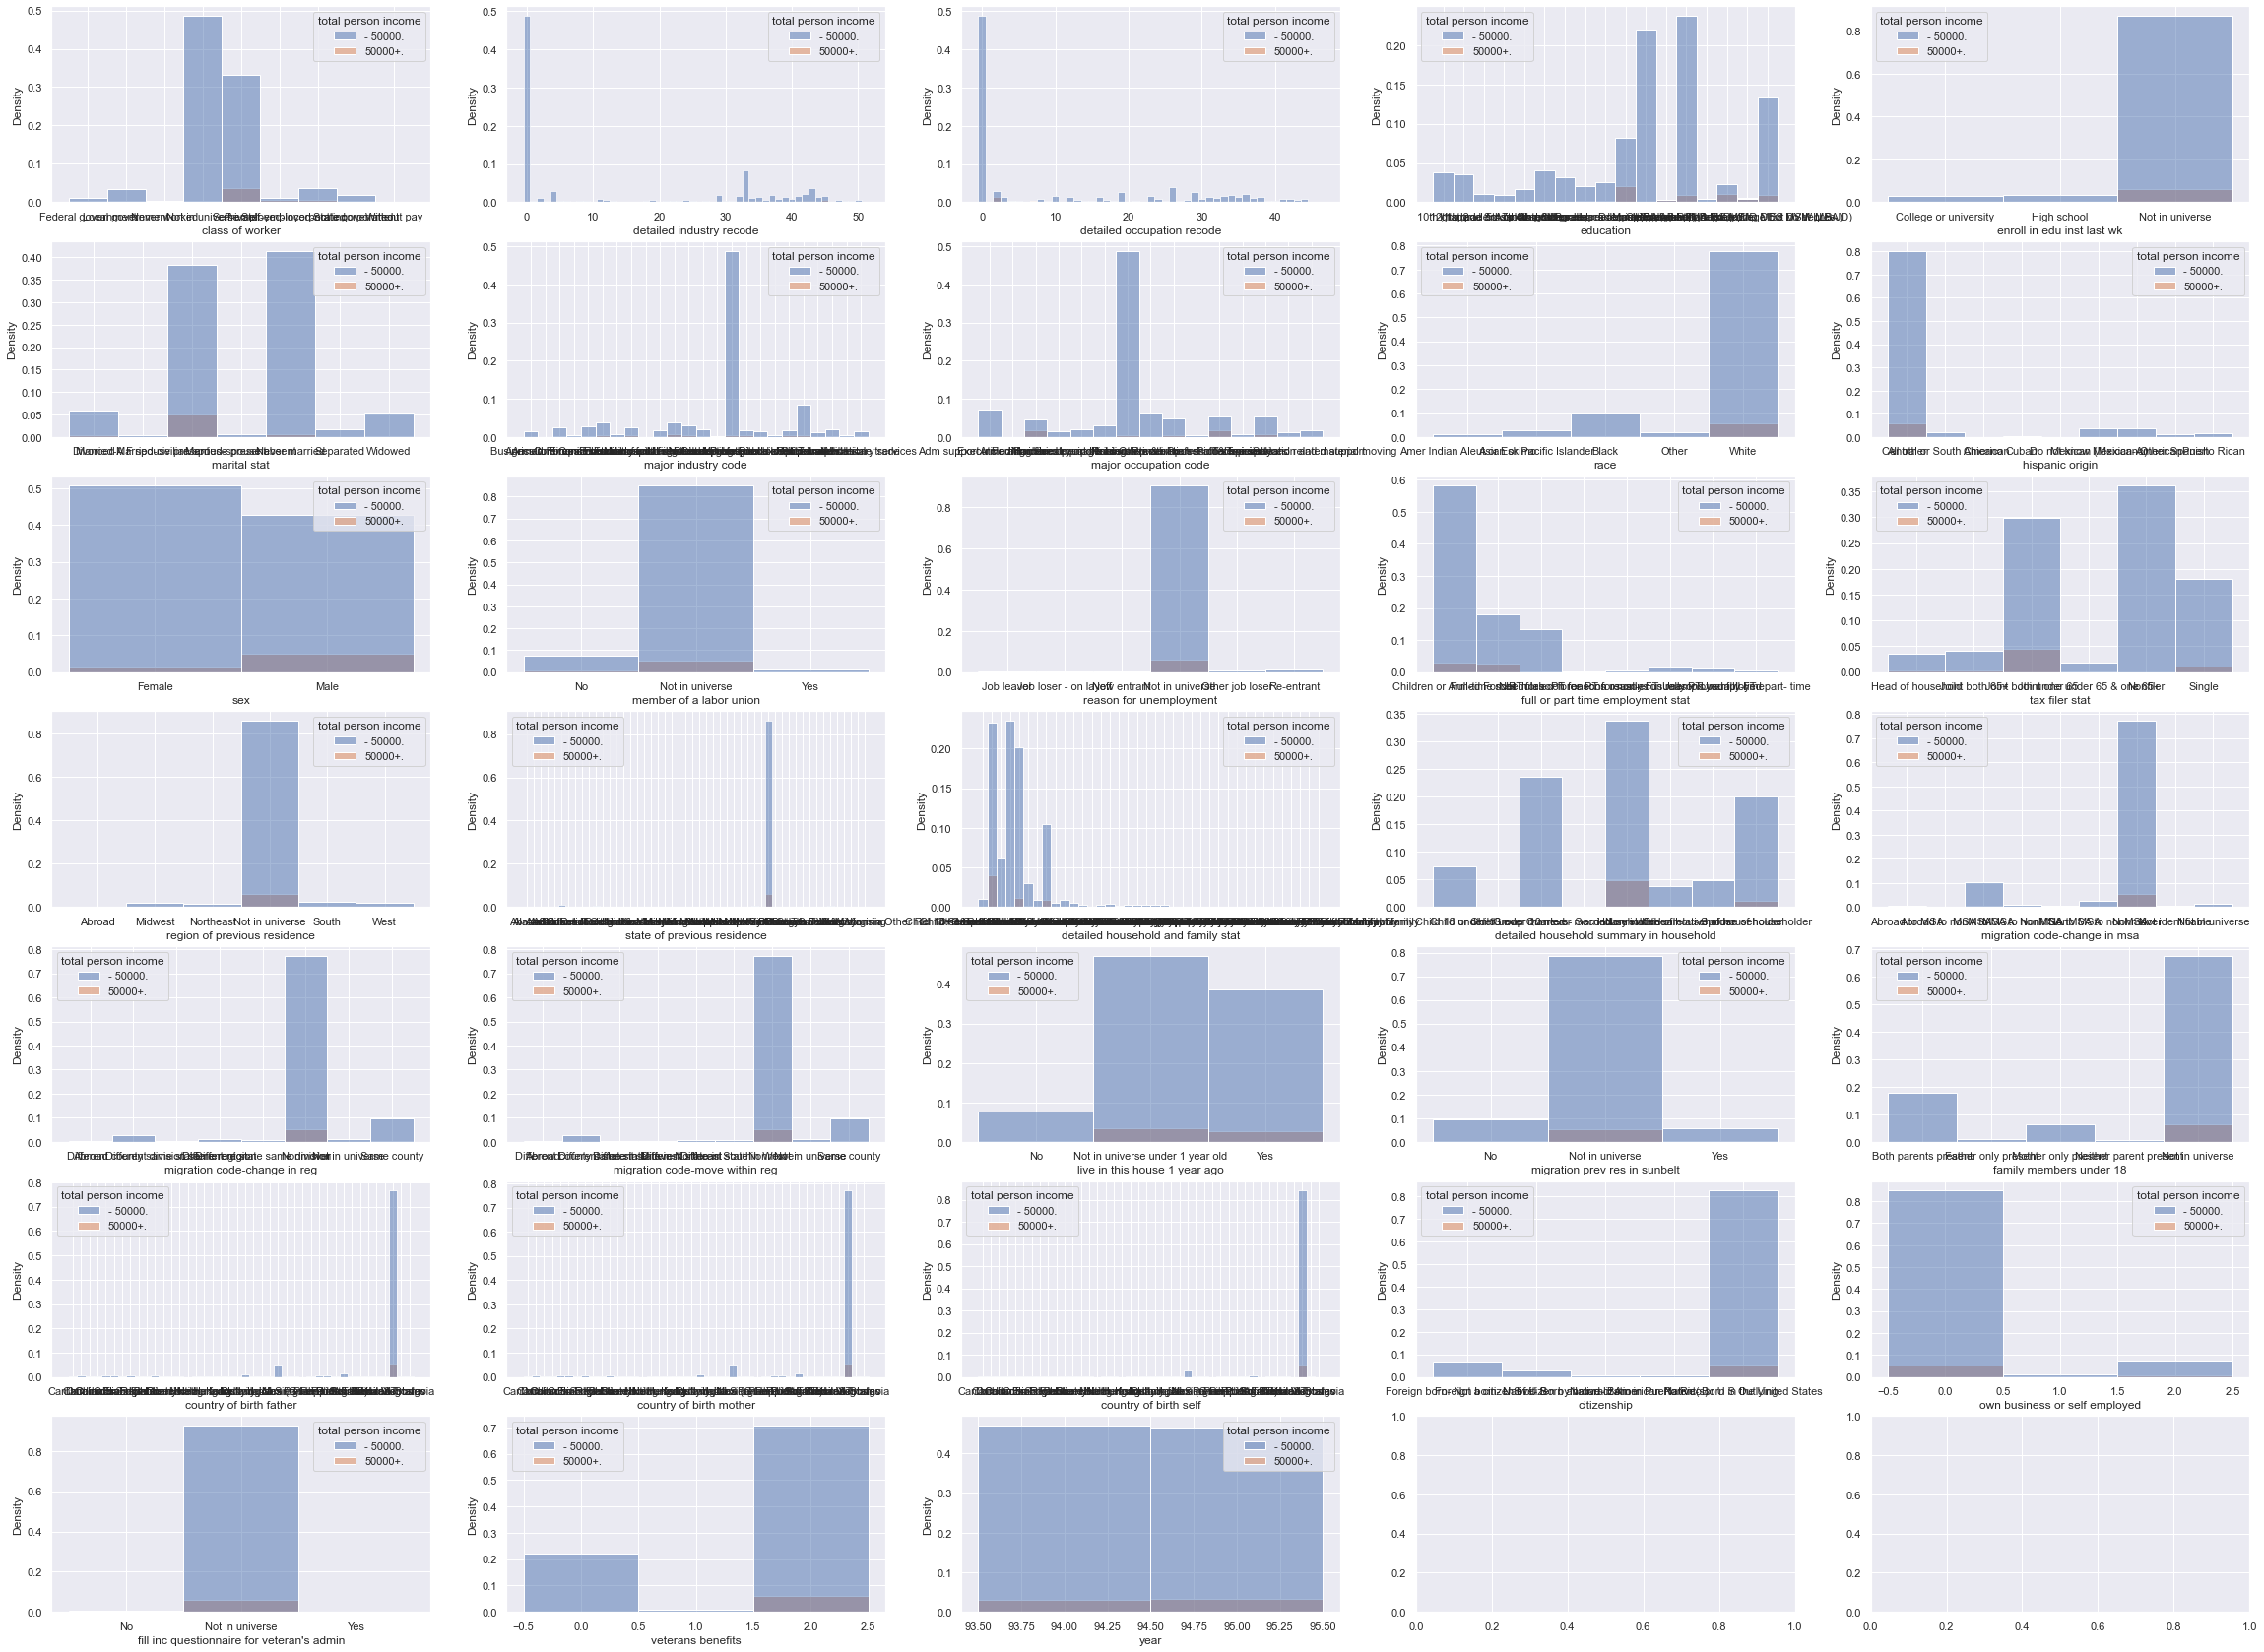

In [12]:
# Show bar chart for categorical features distribution
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(40, 30))
for i, col in enumerate(cat_cols):
    sns.histplot(data, x=col, hue="total person income", stat="density", ax=axs.flatten()[i])

From the above, we can already see that :
- There is an overlap of our two target classes in pretty much all the variables
- There are only two binary variables : sex and year. As a side note, we can assume that the latter might not carry much information and could be dropped
- 

##### 1.5 : Dependency between variables

<AxesSubplot:>

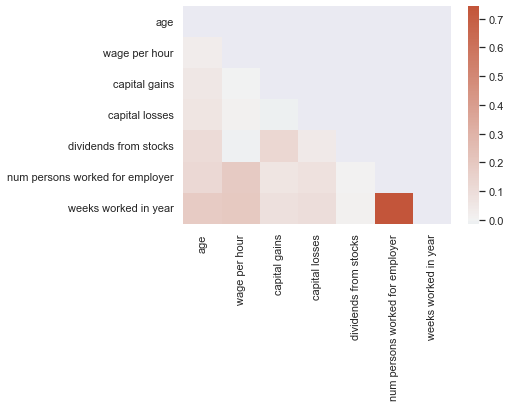

In [32]:
# Check correlation coefficient between continous variables
import numpy as np

corr = data.drop("instance weight", axis=1).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, mask=mask)

We can spot one strong correlation between the number of weeks worked in year and the number of persons working for employer.

In reality, the former can be approximated to a binary categorical variable (did not work/worked). Additionnaly, we saw that the latter had been mapped to a discrete variable with 7 different values (0 to 6)

In conclusion, this coefficient might not mean much, as we can see on the plot below

<AxesSubplot:xlabel='num persons worked for employer', ylabel='weeks worked in year'>

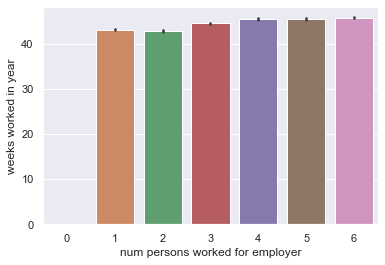

In [29]:
sns.barplot(x=data["num persons worked for employer"], y=data["weeks worked in year"])

##### 1.6 : Relationships between target and variables

In [14]:
# Separating dataset based on output category
data_under50 = data[data["total person income"] == "- 50000."]
data_over50 = data[data["total person income"] == "50000+."]

In [15]:
# Distribution of target classes
print("Under 50k :" + str(len(data_under50)/len(data)))
print("Over 50k :" + str(len(data_over50)/len(data)))

Under 50k :0.9365305076055375
Over 50k :0.06346949239446248


As we saw earlier, the target variable is heavily skewed towards the "under 50k" class. We might therefore consider picking precision/recall or F1 score as evaluation metric for our model later on, rather than accuracy.

**Age**

We can simply look at density plots for this continous variables

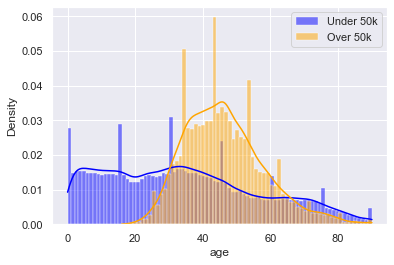

In [17]:
plt.figure()
sns.histplot(data_under50, x="age", stat="density", kde=True, label="Under 50k", color="blue")
sns.histplot(data_over50, x="age", stat="density", kde=True, label="Over 50k", color="orange")
plt.legend()

- Between 0 & 20, the "under 50k" class is almost exclusively represented
- On the other hand, for "middle range" ages, this variable does not seem to be able to discriminate (huge overlap)

**Wage per hour, capital gains & losses, dividends**

These are heavily skewed variables with lots of zeros, we can try looking at the square root rather than the variable directly

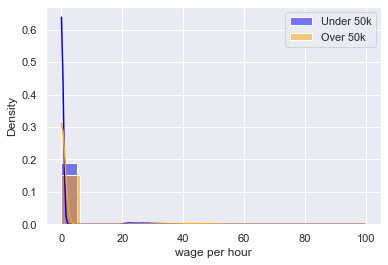

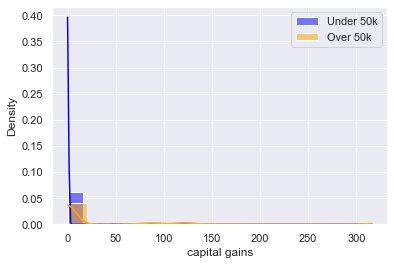

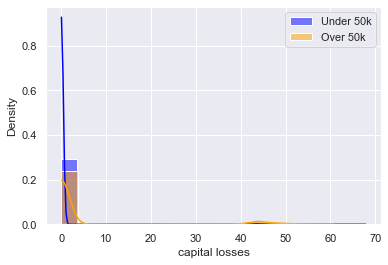

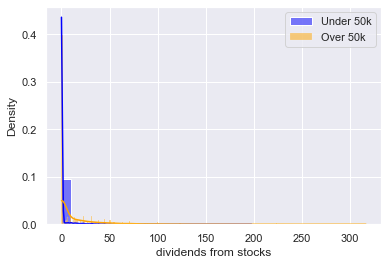

In [27]:
for col in ["wage per hour", "capital gains", "capital losses", "dividends from stocks"]:
    plt.figure()
    sns.histplot(x=np.sqrt(data_under50[col]), stat="density", kde=True, label="Under 50k", color="blue")
    sns.histplot(x=np.sqrt(data_over50[col]), stat="density", kde=True, label="Over 50k", color="orange")
    plt.legend()

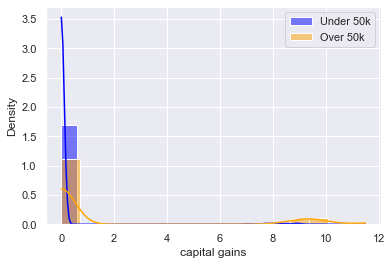

In [26]:
plt.figure()
sns.histplot(x=np.log(1 + data_under50["capital gains"]), stat="density", kde=True, label="Under 50k", color="blue")
sns.histplot(x=np.log(1 + data_over50["capital gains"]), stat="density", kde=True, label="Over 50k", color="orange")
plt.legend()

**Wage per hour, capital gain, capital losses, dividends from stocks**

Considering the overwhelmingly large number of zeros in the distributions of theses variables, we might consider mapping them to binary variable (zero/not zero)

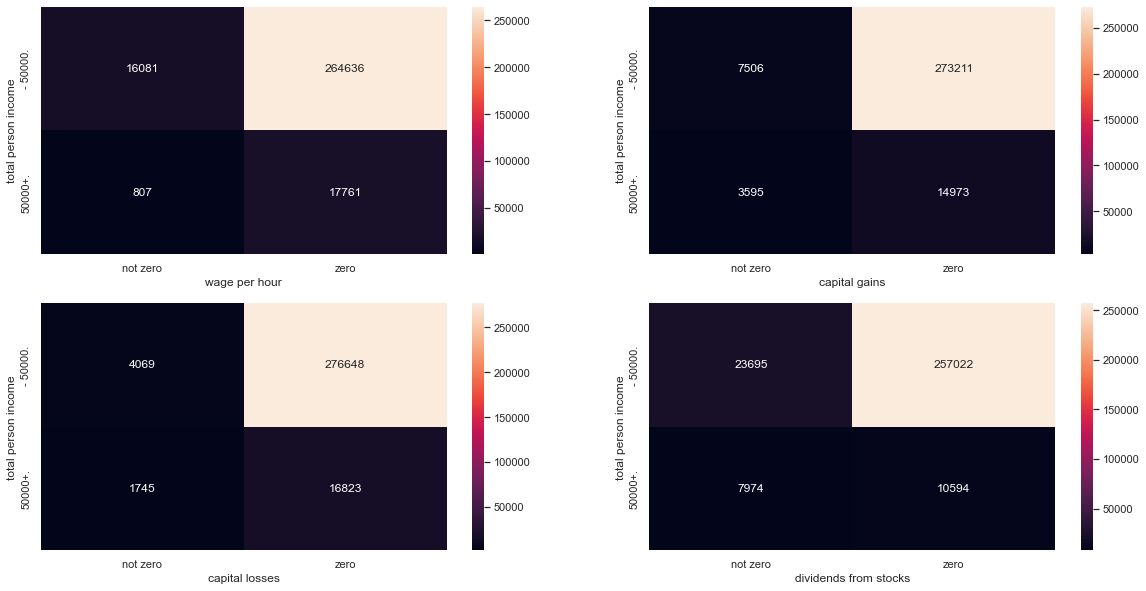

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [123]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
for i, col in enumerate(["wage per hour", "capital gains", "capital losses", "dividends from stocks"]):
    plt.figure()
    sns.heatmap(pd.crosstab(data["total person income"], data[col].map(lambda val: "not zero" if val > 0 else "zero")), annot=True, fmt='d', ax=axs.flatten()[i])